In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
import numpy.ma as ma

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
sys.path.append("../tools")
from feature_format import featureFormat


In [5]:
with open("../impl/final_project_dataset.pkl") as f:
    dataset = pickle.load(f)

In [6]:
df = pd.DataFrame.from_dict(dataset, orient="index")

In [7]:
df.shape

(146, 21)

In [8]:
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


Convert types to float 

In [9]:
df.replace('NaN', np.nan, inplace=True)

for c in (set(df.columns) - {"poi","email_address"}):
    df[c] = df[c].astype(np.float)
    

Initially there are 146 data points (persons) and 18 from them are POI (nearly 12%)

In [10]:
df.poi.value_counts(dropna=False)

False    128
True      18
Name: poi, dtype: int64

35 persons does not have email information, no one from them are POI 

In [11]:
df.loc[:,df.dtypes != np.float].notnull().sum() / df.shape[0]

poi              1.000000
email_address    0.760274
dtype: float64

Overall statistics of all features shows that there are possibly some outliers

In [12]:
desc = df.describe().transpose()
desc["notnull_perc"] = desc["count"] / len(df)
desc

,count,mean,std,min,25%,50%,75%,max,notnull_perc
salary,95.0,5.621943e+05,2.716369e+06,477.0,211816.00,259996.0,312117.00,26704229.0,0.650685
to_messages,86.0,2.073860e+03,2.582701e+03,57.0,541.25,1211.0,2634.75,15149.0,0.589041
deferral_payments,39.0,1.642674e+06,5.161930e+06,-102500.0,81573.00,227449.0,1002671.50,32083396.0,0.267123
total_payments,125.0,5.081526e+06,2.906172e+07,148.0,394475.00,1101393.0,2093263.00,309886585.0,0.856164
exercised_stock_options,102.0,5.987054e+06,3.106201e+07,3285.0,527886.25,1310813.5,2547724.00,311764000.0,0.698630
bonus,82.0,2.374235e+06,1.071333e+07,70000.0,431250.00,769375.0,1200000.00,97343619.0,0.561644
restricted_stock,110.0,2.321741e+06,1.251828e+07,-2604490.0,254018.00,451740.0,1002369.75,130322299.0,0.753425
shared_receipt_with_poi,86.0,1.176465e+03,1.178318e+03,2.0,249.75,740.5,1888.25,5521.0,0.589041
restricted_stock_deferred,18.0,1.664106e+05,4.201494e+06,-7576788.0,-389621.75,-146975.0,-75009.75,15456290.0,0.123288
total_stock_value,126.0,6.773957e+06,3.895777e+07,-44093.0,494510.25,1102872.5,2949846.75,434509511.0,0.863014


Some features have very small number of non-null values

In [13]:
desc[desc.notnull_perc<0.3]

,count,mean,std,min,25%,50%,75%,max,notnull_perc
deferral_payments,39.0,1.642674e+06,5.161930e+06,-102500.0,81573.00,227449.0,1002671.50,32083396.0,0.267123
restricted_stock_deferred,18.0,1.664106e+05,4.201494e+06,-7576788.0,-389621.75,-146975.0,-75009.75,15456290.0,0.123288
loan_advances,4.0,4.196250e+07,4.708321e+07,400000.0,1600000.00,41762500.0,82125000.00,83925000.0,0.027397
director_fees,17.0,1.668049e+05,3.198914e+05,3285.0,98784.00,108579.0,113784.00,1398517.0,0.116438


Variable loan_advances should be removed. In order to stay consistend with total_payments, its existing values can be added to "other" variable.

For example, consider the following scatter plot

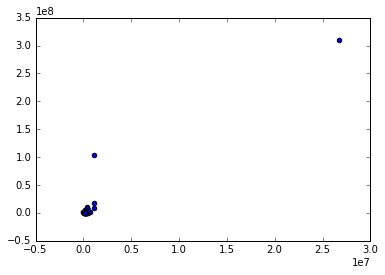

In [14]:
plt.scatter(df.salary, df.total_payments, )

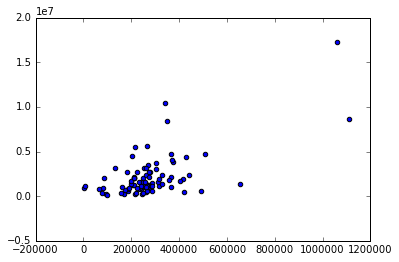

In [15]:
mask = (df.salary < 2.5*10**7) & (df.total_payments<10**8)
plt.scatter(df.salary[mask], df.total_payments[mask] )

Who are these outliers?

In [16]:
df[~mask & df.salary.notnull()]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,NaN,49110078.0,...,81525000.0,36.0,10359729.0,16.0,True,NaN,-300000.0,3600000.0,kenneth.lay@enron.com,123.0
TOTAL,26704229.0,NaN,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,NaN,-7576788.0,434509511.0,...,83925000.0,NaN,42667589.0,NaN,False,1398517.0,-27992891.0,48521928.0,NaN,NaN


The first one is Ken Lay - key figure in Enron scandal. However, "TOTAL" is definitely an outlier and should be romoved. 

In [17]:
df.drop("TOTAL", axis=0, inplace=True)

New overall statistics after removing outlier 

In [18]:
desc = df.describe().transpose()
desc["count"] = desc["count"] / len(df)
desc["range"] = abs(desc["max"] - desc["min"]) /abs(desc["min"]) 
desc

,count,mean,std,min,25%,50%,75%,max,range
salary,0.648276,2.840875e+05,1.771311e+05,477.0,211802.00,258741.0,308606.50,1111258.0,2.328681e+03
to_messages,0.593103,2.073860e+03,2.582701e+03,57.0,541.25,1211.0,2634.75,15149.0,2.647719e+02
deferral_payments,0.262069,8.416025e+05,1.289323e+06,-102500.0,79644.50,221063.5,867211.25,6426990.0,6.370234e+01
total_payments,0.855172,2.623421e+06,9.488106e+06,148.0,386380.25,1100246.5,2084662.75,103559793.0,6.997273e+05
exercised_stock_options,0.696552,2.959559e+06,5.499450e+06,3285.0,506765.00,1297049.0,2542813.00,34348384.0,1.045513e+04
bonus,0.558621,1.201773e+06,1.441679e+06,70000.0,425000.00,750000.0,1200000.00,8000000.0,1.132857e+02
restricted_stock,0.751724,1.147424e+06,2.249770e+06,-2604490.0,252055.00,441096.0,985032.00,14761694.0,6.667787e+00
shared_receipt_with_poi,0.593103,1.176465e+03,1.178318e+03,2.0,249.75,740.5,1888.25,5521.0,2.759500e+03
restricted_stock_deferred,0.117241,6.218928e+05,3.845528e+06,-1787380.0,-329825.00,-140264.0,-72419.00,15456290.0,9.647456e+00
total_stock_value,0.862069,3.352073e+06,6.532883e+06,-44093.0,494136.00,1095040.0,2606763.00,49110078.0,1.114784e+03


### Cross Check with total_payment and total_stock_value

Variables total_payment and total_stock_value seem to be a sum of some other variables. 

There for they can be used for cross check and detection of data inconsistency 

In [19]:
total_payment_const = ["salary", "bonus", "long_term_incentive", "deferred_income", "deferral_payments", 
                       "loan_advances", "other", "expenses" , "director_fees"]
not_eq = df[total_payment_const].sum(axis=1) != df.total_payments.replace(to_replace=np.nan, value=0)

In [20]:
df[not_eq][total_payment_const + ["total_payments"]]

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BELFER ROBERT,NaN,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0
BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0


In [21]:
df.deferral_payments.sort_values().head()

BELFER ROBERT     -102500.0
HAYES ROBERT E       7961.0
HIRKO JOSEPH        10259.0
THORN TERENCE H     16586.0
COLWELL WESLEY      27610.0
Name: deferral_payments, dtype: float64

Negative deferral payments? Only one negative value - not typical. It is possibly an error

In [22]:
total_stock_value_const = ["exercised_stock_options", "restricted_stock", "restricted_stock_deferred"]
not_eq = df[total_stock_value_const].sum(axis=1) != df.total_stock_value.replace(to_replace=np.nan, value=0)

In [23]:
df[not_eq][total_stock_value_const + ["total_stock_value"]]

,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
BELFER ROBERT,3285.0,NaN,44093.0,-44093.0
BHATNAGAR SANJAY,2604490.0,-2604490.0,15456290.0,NaN


Cross check by two variables revealed two inconsistent records: BELFER ROBERT and BHATNAGAR SANJAY

In [24]:
ordered_columns = total_payment_const + ["total_payments"] + \
                total_stock_value_const + ["total_stock_value"]
    
df.loc[["BELFER ROBERT", "BHATNAGAR SANJAY"],ordered_columns].transpose()

,BELFER ROBERT,BHATNAGAR SANJAY
salary,NaN,NaN
bonus,NaN,NaN
long_term_incentive,NaN,NaN
deferred_income,NaN,NaN
deferral_payments,-102500.0,NaN
loan_advances,NaN,NaN
other,NaN,137864.0
expenses,NaN,NaN
director_fees,3285.0,137864.0
total_payments,102500.0,15456290.0


Considering these two records, we can notice, that possibly there were shift in the data (Note that data fields were presented  in the same as it was in original document from Find Law)
For Belfer data was "shifted down" and for BHATNAGAR is was "shifted up" 

Fix inconsistent data 

In [25]:
fixed_df = df.copy()

fix_pers = {
    "BELFER ROBERT" : 1,
    "BHATNAGAR SANJAY" : -1    
}

len_col = len(ordered_columns)
for person, shift in fix_pers.items(): 
    for i in range(len_col):
        if i+shift<0 or i+shift>=len(ordered_columns):
            print i+shift
            fixed_df.loc[person, ordered_columns[i]] = np.nan
        else:
            fixed_df.loc[person, ordered_columns[i]] = df.loc[person, ordered_columns[i+shift]]
        

14
-1


In [26]:
fixed_df.loc[["BELFER ROBERT", "BHATNAGAR SANJAY"],ordered_columns].transpose()

,BELFER ROBERT,BHATNAGAR SANJAY
salary,NaN,NaN
bonus,NaN,NaN
long_term_incentive,NaN,NaN
deferred_income,-102500.0,NaN
deferral_payments,NaN,NaN
loan_advances,NaN,NaN
other,NaN,NaN
expenses,3285.0,137864.0
director_fees,102500.0,NaN
total_payments,3285.0,137864.0


Overall statistics for fixed data

In [27]:
desc = fixed_df.describe().transpose()
desc["count"] = desc["count"] / len(df)
desc["range"] = (desc["max"] - desc["min"]) /desc["min"] 
desc

,count,mean,std,min,25%,50%,75%,max,range
salary,0.648276,2.840875e+05,1.771311e+05,477.0,211802.00,258741.0,308606.50,1111258.0,2.328681e+03
to_messages,0.593103,2.073860e+03,2.582701e+03,57.0,541.25,1211.0,2634.75,15149.0,2.647719e+02
deferral_payments,0.255172,8.671188e+05,1.297344e+06,7961.0,85430.00,227449.0,875307.00,6426990.0,8.063094e+02
total_payments,0.855172,2.499085e+06,9.419345e+06,148.0,361647.00,1095881.5,2056143.75,103559793.0,6.997273e+05
exercised_stock_options,0.689655,3.117640e+06,5.657924e+06,9803.0,570128.75,1310813.5,2544450.00,34348384.0,3.502865e+03
bonus,0.558621,1.201773e+06,1.441679e+06,70000.0,425000.00,750000.0,1200000.00,8000000.0,1.132857e+02
restricted_stock,0.758621,1.184748e+06,2.217008e+06,32460.0,254018.00,451740.0,1002369.75,14761694.0,4.537657e+02
shared_receipt_with_poi,0.593103,1.176465e+03,1.178318e+03,2.0,249.75,740.5,1888.25,5521.0,2.759500e+03
restricted_stock_deferred,0.117241,-4.456934e+05,6.934388e+05,-2604490.0,-409554.00,-153686.0,-82782.00,-32460.0,-9.875369e-01
total_stock_value,0.862069,3.476076e+06,6.614499e+06,28798.0,495633.00,1110705.0,3064208.00,49110078.0,1.704329e+03


Note that total_payments and total stock value can be restored from other data

In [28]:
fixed_df.loc[fixed_df.total_payments.isnull(), total_payment_const].sum(axis=1)

CHAN RONNIE               0.0
CHRISTODOULOU DIOMEDES    0.0
CLINE KENNETH W           0.0
CORDES WILLIAM R          0.0
FOWLER PEGGY              0.0
GATHMANN WILLIAM D        0.0
GILLIS JOHN               0.0
HAYSLETT RODERICK J       0.0
HUGHES JAMES A            0.0
LEWIS RICHARD             0.0
LOCKHART EUGENE E         0.0
LOWRY CHARLES P           0.0
MCCARTY DANNY J           0.0
MCDONALD REBECCA          0.0
MORAN MICHAEL P           0.0
PIRO JIM                  0.0
POWERS WILLIAM            0.0
SCRIMSHAW MATTHEW         0.0
SHERRICK JEFFREY B        0.0
WHALEY DAVID A            0.0
WROBEL BRUCE              0.0
dtype: float64

In [29]:
fixed_df.loc[fixed_df.total_stock_value.isnull(), total_stock_value_const].sum(axis=1)

BELFER ROBERT                    0.0
BLAKE JR. NORMAN P               0.0
BROWN MICHAEL                    0.0
CARTER REBECCA C                 0.0
CHAN RONNIE                      0.0
DODSON KEITH                     0.0
GRAMM WENDY L                    0.0
GRAY RODNEY                      0.0
LOCKHART EUGENE E                0.0
MENDELSOHN JOHN                  0.0
MEYER JEROME J                   0.0
PEREIRA PAULO V. FERRAZ          0.0
POWERS WILLIAM                   0.0
SAVAGE FRANK                     0.0
THE TRAVEL AGENCY IN THE PARK    0.0
UMANOFF ADAM S                   0.0
URQUHART JOHN A                  0.0
WAKEHAM JOHN                     0.0
WINOKUR JR. HERBERT S            0.0
WODRASKA JOHN                    0.0
dtype: float64

There is no inconsistencies in missed total values, missing value means zero total value

In [30]:
(fixed_df.notnull().sum(axis=1) / fixed_df.shape[1]).describe(percentiles=[.01,.1,.25,.5,.75,.9,.99])

count    145.000000
mean       0.555993
std        0.218570
min        0.047619
1%         0.142857
10%        0.238095
25%        0.428571
50%        0.571429
75%        0.761905
90%        0.790476
99%        0.904762
max        0.904762
dtype: float64

Note that some people have very low number of not null information. Nearly 10% have less than 23% of data 

In [31]:
(fixed_df[fixed_df.columns.difference(["poi"])].notnull().sum(axis=1) / fixed_df.shape[1]).sort_values().head()

LOCKHART EUGENE E                0.000000
WROBEL BRUCE                     0.095238
WHALEY DAVID A                   0.095238
THE TRAVEL AGENCY IN THE PARK    0.095238
GRAMM WENDY L                    0.095238
dtype: float64

LOCKHART EUGENE E has no feature data (only POI identifier) 

In [32]:
fixed_df.drop("LOCKHART EUGENE E", axis=0, inplace=True)

### Consider distributions and correlations

In [33]:
total_payment_const

['salary',
 'bonus',
 'long_term_incentive',
 'deferred_income',
 'deferral_payments',
 'loan_advances',
 'other',
 'expenses',
 'director_fees']

In [34]:
desc_range = fixed_df.describe(percentiles=[0.05, 0.25, 0.75, 0.95]).transpose()
desc_range["Outl_left_dist"] = abs(desc_range["min"] - desc_range["25%"] + 1.5*(desc_range["75%"] - desc_range["25%"]))
desc_range["Outl_right_dist"] = abs(desc_range["max"] + desc_range["75%"] + 1.5*(desc_range["75%"] - desc_range["25%"]))
desc_range[["min", "Outl_left_dist", "5%", "95%", "Outl_right_dist", "max"]]


,min,Outl_left_dist,5%,95%,Outl_right_dist,max
salary,477.0,6.611825e+04,83714.40,498671.15,1.565071e+06,1111258.0
to_messages,57.0,2.656000e+03,130.00,7301.00,2.092400e+04,15149.0
deferral_payments,7961.0,1.107346e+06,15320.60,2997976.80,8.487112e+06,6426990.0
total_payments,148.0,2.180246e+06,10958.15,5388582.35,1.081577e+08,103559793.0
exercised_stock_options,9803.0,2.401156e+06,83127.25,15368773.15,3.985432e+07,34348384.0
bonus,70000.0,8.075000e+05,200000.00,4175000.00,1.036250e+07,8000000.0
restricted_stock,32460.0,9.009696e+05,108717.95,4046598.00,1.688659e+07,14761694.0
shared_receipt_with_poi,2.0,2.210000e+03,22.25,3661.50,9.867000e+03,5521.0
restricted_stock_deferred,-2604490.0,1.704778e+06,-1950802.00,-41766.40,3.749160e+05,-32460.0
total_stock_value,28798.0,3.386028e+06,128647.60,15039735.40,5.602715e+07,49110078.0


Boxplot for  salary


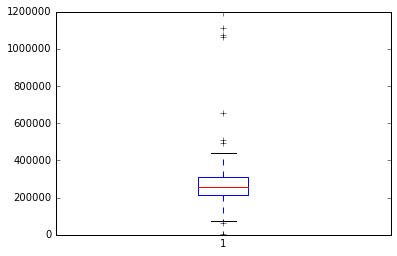

Boxplot for  bonus


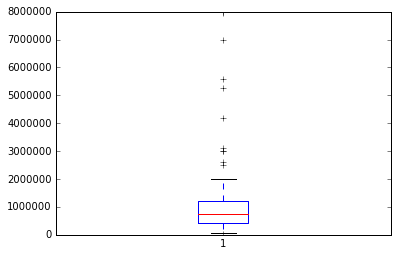

Boxplot for  long_term_incentive


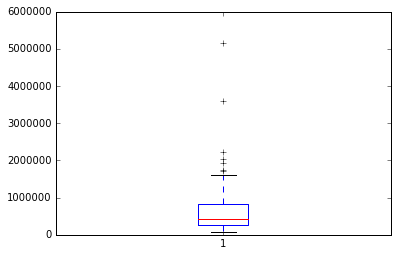

Boxplot for  deferred_income


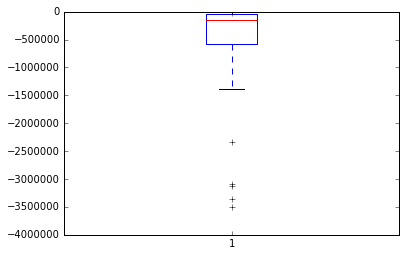

Boxplot for  deferral_payments


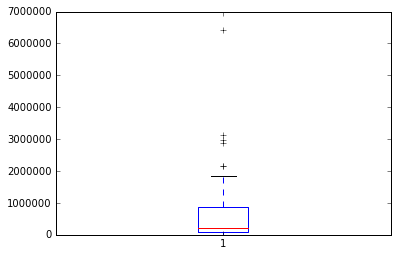

Boxplot for  loan_advances


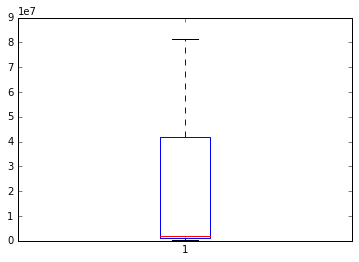

Boxplot for  other


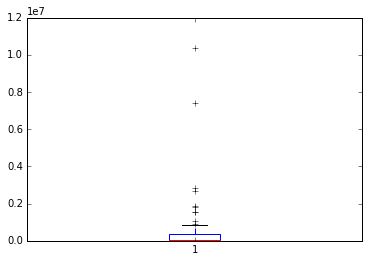

Boxplot for  expenses


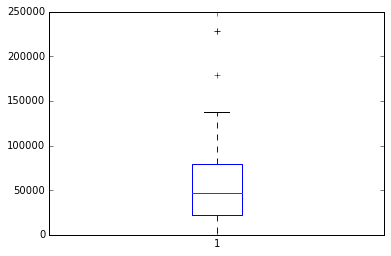

Boxplot for  director_fees


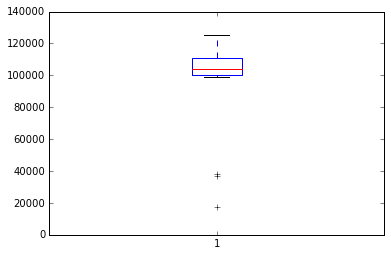

In [35]:
for c in total_payment_const:
    keep = fixed_df[c].notnull()
    print "Boxplot for ", c
    plt.boxplot(fixed_df.loc[keep, c])
    plt.show()

In [36]:
fixed_df[fixed_df.salary > 800000]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
FREVERT MARK A,1060932.0,3275.0,6426990.0,17252530.0,10433518.0,2000000.0,4188667.0,2979.0,NaN,14622185.0,...,2000000.0,21.0,7427621.0,6.0,False,NaN,-3367011.0,1617011.0,mark.frevert@enron.com,242.0
LAY KENNETH L,1072321.0,4273.0,202911.0,103559793.0,34348384.0,7000000.0,14761694.0,2411.0,NaN,49110078.0,...,81525000.0,36.0,10359729.0,16.0,True,NaN,-300000.0,3600000.0,kenneth.lay@enron.com,123.0
SKILLING JEFFREY K,1111258.0,3627.0,NaN,8682716.0,19250000.0,5600000.0,6843672.0,2042.0,NaN,26093672.0,...,NaN,108.0,22122.0,30.0,True,NaN,NaN,1920000.0,jeff.skilling@enron.com,88.0


In [37]:
fixed_df.salary.sort_values().head()

BANNANTINE JAMES M      477.0
GRAY RODNEY            6615.0
WESTFAHL RICHARD K    63744.0
REYNOLDS LAWRENCE     76399.0
BAZELIDES PHILIP J    80818.0
Name: salary, dtype: float64

In [38]:
fixed_df.loc[["BANNANTINE JAMES M", "GRAY RODNEY"],total_payment_const + ["total_payments"] +
            total_stock_value_const + ["total_stock_value"]].transpose()

,BANNANTINE JAMES M,GRAY RODNEY
salary,477.0,6615.0
bonus,NaN,NaN
long_term_incentive,NaN,365625.0
deferred_income,-5104.0,NaN
deferral_payments,NaN,93585.0
loan_advances,NaN,NaN
other,864523.0,680833.0
expenses,56301.0,NaN
director_fees,NaN,NaN
total_payments,916197.0,1146658.0


Difference with Find LAW for BANNANTINE JAMES M!!
expenses = 56301.0, total_payments = expenses = 56301.0

In [39]:
fixed_df.loc["BANNANTINE JAMES M", set(total_payment_const) - {"expenses"} ] = np.nan
fixed_df.loc["BANNANTINE JAMES M", "total_payments"] = fixed_df.loc["BANNANTINE JAMES M", "expenses"] 

In [40]:
fixed_df.loc["BANNANTINE JAMES M", ordered_columns]

salary                               NaN
bonus                                NaN
long_term_incentive                  NaN
deferred_income                      NaN
deferral_payments                    NaN
loan_advances                        NaN
other                                NaN
expenses                           56301
director_fees                        NaN
total_payments                     56301
exercised_stock_options      4.04616e+06
restricted_stock             1.75755e+06
restricted_stock_deferred        -560222
total_stock_value            5.24349e+06
Name: BANNANTINE JAMES M, dtype: object

In [41]:
fixed_df[fixed_df.other < 62]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
WALLS JR ROBERT H,357091.0,671.0,NaN,1798780.0,4346544.0,850000.0,1552453.0,215.0,NaN,5898997.0,...,NaN,146.0,2.0,0.0,False,NaN,NaN,540751.0,rob.walls@enron.com,17.0


### Checking for multicollinearity

Next we will consider Variance Inflation Factor (VIF) for different features

In [42]:
def get_VIF(df, incl):
    matrix = df[incl].dropna() 
    print "Resulting matrix shape ", matrix.shape
    vifs = {}
    for i, col in enumerate(incl):
        vifs[col] = variance_inflation_factor(matrix.values, i)
    return sorted(vifs.items(), key = lambda (key, value): value, reverse=True)

In [43]:
nodata = desc.loc[desc["count"]<0.5].index

incl = [c for c in ordered_columns if c not in nodata]
get_VIF(fixed_df, incl)

Resulting matrix shape  (52, 8)


[('total_stock_value', 1664.3870554571345),
 ('exercised_stock_options', 833.85462163562306),
 ('restricted_stock', 205.01587764446822),
 ('salary', 7.9168358692039389),
 ('total_payments', 6.4650628256446989),
 ('other', 5.7405032706709607),
 ('bonus', 3.5296528435695671),
 ('expenses', 2.5447118592000977)]

In [44]:
incl = [c for c in total_payment_const if c not in nodata]
get_VIF(fixed_df, incl)

Resulting matrix shape  (68, 4)


[('salary', 4.73711742550433),
 ('bonus', 2.4689357036174906),
 ('expenses', 2.295677869578761),
 ('other', 1.5753625855494151)]

In [45]:
incl = [c for c in total_stock_value_const if c not in nodata]
get_VIF(fixed_df, incl)

Resulting matrix shape  (82, 2)


[('exercised_stock_options', 2.433984691922209),
 ('restricted_stock', 2.4339846919222081)]

In [46]:
incl = [c for c in (total_payment_const + total_stock_value_const) if c not in nodata]
get_VIF(fixed_df, incl)

Resulting matrix shape  (52, 6)


[('salary', 6.2665335560476008),
 ('exercised_stock_options', 4.1901954484369863),
 ('restricted_stock', 2.9262247506299071),
 ('bonus', 2.5726070141165689),
 ('expenses', 2.4519529088431042),
 ('other', 2.3463995586706154)]

In [47]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler

In [48]:
scaler = StandardScaler()
data = fixed_df[["salary", "exercised_stock_options", "restricted_stock",
             "bonus", "expenses", "other"]].dropna()

data_scaled = scaler.fit_transform(data)

In [49]:

model = OLS(data_scaled[:,0], add_constant(data_scaled[:,1:]), missing='drop', )
results = model.fit()
print(results.summary(yname="salary",xname= ["const"] + list(data.columns[1:])))

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     16.68
Date:                Fri, 02 Dec 2016   Prob (F-statistic):           2.24e-09
Time:                        09:18:16   Log-Likelihood:                -46.893
No. Observations:                  52   AIC:                             105.8
Df Residuals:                      46   BIC:                             117.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                   -5

There is a slight multicollinearity for salary, exercised_stock_options, bonus and other

In [50]:
my_dataset = fixed_df.to_dict(orient="index")

In [51]:
fixed_df["from_poi_perc"] = fixed_df["from_poi_to_this_person"]/fixed_df["to_messages"]
fixed_df["to_poi_perc"] = fixed_df["from_this_person_to_poi"]/fixed_df["from_messages"]


In [52]:
fixed_df["to_poi_perc"].describe()

count    86.000000
mean      0.184055
std       0.210610
min       0.000000
25%       0.012421
50%       0.100574
75%       0.272039
max       1.000000
Name: to_poi_perc, dtype: float64

In [53]:
fixed_df

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person,from_poi_perc,to_poi_perc
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,152.0,65.0,False,NaN,-3081055.0,304805.0,phillip.allen@enron.com,47.0,0.016196,0.029613
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,NaN,566.0,NaN,56301.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,...,NaN,0.0,False,NaN,NaN,NaN,james.bannantine@enron.com,39.0,0.068905,0.000000
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,NaN,10623258.0,...,2660303.0,NaN,False,NaN,-1386055.0,1586055.0,NaN,NaN,NaN,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,145796.0,NaN,-82782.0,63014.0,...,69.0,NaN,False,NaN,-201641.0,NaN,frank.bay@enron.com,NaN,NaN,NaN
BAZELIDES PHILIP J,80818.0,NaN,684694.0,860136.0,1599641.0,NaN,NaN,NaN,NaN,1599641.0,...,874.0,NaN,False,NaN,NaN,93750.0,NaN,NaN,NaN,NaN
BECK SALLY W,231330.0,7315.0,NaN,969068.0,NaN,700000.0,126027.0,2639.0,NaN,126027.0,...,566.0,386.0,False,NaN,NaN,NaN,sally.beck@enron.com,144.0,0.019686,0.088879
BELDEN TIMOTHY N,213999.0,7991.0,2144013.0,5501630.0,953136.0,5249999.0,157569.0,5521.0,NaN,1110705.0,...,210698.0,108.0,True,NaN,-2334434.0,NaN,tim.belden@enron.com,228.0,0.028532,0.223140
BELFER ROBERT,NaN,NaN,NaN,3285.0,NaN,NaN,44093.0,NaN,-44093.0,NaN,...,NaN,NaN,False,102500.0,-102500.0,NaN,NaN,NaN,NaN,NaN
BERBERIAN DAVID,216582.0,NaN,NaN,228474.0,1624396.0,NaN,869220.0,NaN,NaN,2493616.0,...,NaN,NaN,False,NaN,NaN,NaN,david.berberian@enron.com,NaN,NaN,NaN
